<a href="https://colab.research.google.com/github/sgravan107/sgravan107/blob/main/WM_811k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision scikit-learn matplotlib opencv-python kaggle -q


In [ ]:
import os, zipfile, pathlib
from pathlib import Path

# Upload kaggle.json once per session
from google.colab import files
files.upload()  # select kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download WM-811K
!kaggle datasets download -d qingyi/wm811k-wafer-map -p ./data && ls -lh ./data
!unzip -q -o ./data/wm811k-wafer-map.zip -d ./data/wm811k
!ls -R ./data/wm811k | head -n 50


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/qingyi/wm811k-wafer-map
License(s): CC0-1.0
  0% 0.00/149M [00:00<?, ?B/s]
100% 149M/149M [00:00<00:00, 1.61GB/s]
total 150M
-rw-r--r-- 1 root root 150M Sep 27  2019 wm811k-wafer-map.zip
./data/wm811k:
LSWMD.pkl


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

base = Path("./data/wm811k")
# Find the pickle
pkl_candidates = list(base.rglob("*.pkl"))
assert len(pkl_candidates) > 0, "Could not find a .pkl file in the dataset"
pkl_path = pkl_candidates[0]
print("Using:", pkl_path)

df = pd.read_pickle(pkl_path)
print("Columns:", df.columns.tolist() if hasattr(df, "columns") else type(df))

# Many releases store records in a pandas DataFrame with columns like:
# 'waferMap' (numpy array), 'failureType' (string label), sometimes 'dieSize', 'trianTestLabel'
# If yours differs, print a row to see keys and adjust the names below.

# Infer column names safely
wafer_key = "waferMap" if "waferMap" in df.columns else [c for c in df.columns if "wafer" in c.lower()][0]
label_key = "failureType" if "failureType" in df.columns else [c for c in df.columns if "label" in c.lower()][0]

# Keep only labeled rows
df = df[~df[label_key].isna()].reset_index(drop=True)
df = df.rename(columns={wafer_key:"wafer", label_key:"label"})
df["label"] = df["label"].astype(str)

# Basic stats
df["label"].value_counts()


Using: data/wm811k/LSWMD.pkl
Columns: ['waferMap', 'dieSize', 'lotName', 'waferIndex', 'trianTestLabel', 'failureType']


,count
label,
[],638507
[['none']],147431
[['Edge-Ring']],9680
[['Edge-Loc']],5189
[['Center']],4294
[['Loc']],3593
[['Scratch']],1193
[['Random']],866
[['Donut']],555


In [ ]:
# Cap per class to keep it fast
PER_CLASS = 500  # lower if you want even faster
subset = []
for cls, g in df.groupby("label"):
    subset.append(g.sample(min(PER_CLASS, len(g)), random_state=42))
df_small = pd.concat(subset).sample(frac=1.0, random_state=42).reset_index(drop=True)

classes = sorted(df_small["label"].unique())
cls_to_idx = {c:i for i,c in enumerate(classes)}
len(df_small), classes[:10]


(4649,
 ["[['Center']]",
  "[['Donut']]",
  "[['Edge-Loc']]",
  "[['Edge-Ring']]",
  "[['Loc']]",
  "[['Near-full']]",
  "[['Random']]",
  "[['Scratch']]",
  "[['none']]",
  '[]'])

In [ ]:
import cv2

def to_64x64(x):
    # x is a 2D numpy array of integers 0 or 1 (sometimes more values)
    x = x.astype(np.float32)
    # Normalize to [0,1] if not already
    if x.max() > 0:
        x = x / x.max()
    small = cv2.resize(x, (64, 64), interpolation=cv2.INTER_NEAREST)
    return small

X = []
y = []
for i,row in df_small.iterrows():
    arr = row["wafer"]
    # Some datasets store wafer as list -> convert
    arr = np.array(arr)
    if arr.ndim == 3:
        arr = arr[...,0]
    X.append(to_64x64(arr))
    y.append(cls_to_idx[row["label"]])

X = np.stack(X)                   # [N, 64, 64]
y = np.array(y, dtype=np.int64)   # [N]
X.shape, y.shape


((4649, 64, 64), (4649,))

In [ ]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

class WaferDS(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        img = torch.tensor(self.X[i]).float().unsqueeze(0)  # [1,64,64]
        img = img.repeat(3,1,1)  # [3,64,64] for ResNet
        label = torch.tensor(self.y[i]).long()
        return img, label

train_loader = DataLoader(WaferDS(X_train, y_train), batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(WaferDS(X_val,   y_val),   batch_size=64, shuffle=False, num_workers=2)
len(train_loader), len(val_loader)


(59, 15)

In [ ]:
import torch.nn as nn
from torchvision import models

device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = len(classes)

model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


In [ ]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

def evaluate():
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            pred = logits.argmax(1)
            ys.extend(yb.cpu().tolist())
            ps.extend(pred.cpu().tolist())
    acc = accuracy_score(ys, ps)
    f1  = f1_score(ys, ps, average="macro")
    return acc, f1

EPOCHS = 15  # bump to 10–15 later
for ep in range(1, EPOCHS+1):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        opt.step()
    acc, f1 = evaluate()
    print(f"Epoch {ep} | val acc {acc:.3f} | val macro-F1 {f1:.3f}")


Epoch 1 | val acc 0.666 | val macro-F1 0.656
Epoch 2 | val acc 0.709 | val macro-F1 0.717
Epoch 3 | val acc 0.703 | val macro-F1 0.705
Epoch 4 | val acc 0.563 | val macro-F1 0.561
Epoch 5 | val acc 0.684 | val macro-F1 0.698
Epoch 6 | val acc 0.677 | val macro-F1 0.684
Epoch 7 | val acc 0.726 | val macro-F1 0.733
Epoch 8 | val acc 0.696 | val macro-F1 0.709
Epoch 9 | val acc 0.718 | val macro-F1 0.730
Epoch 10 | val acc 0.718 | val macro-F1 0.733
Epoch 11 | val acc 0.698 | val macro-F1 0.702
Epoch 12 | val acc 0.710 | val macro-F1 0.710
Epoch 13 | val acc 0.724 | val macro-F1 0.729
Epoch 14 | val acc 0.720 | val macro-F1 0.730
Epoch 15 | val acc 0.682 | val macro-F1 0.673


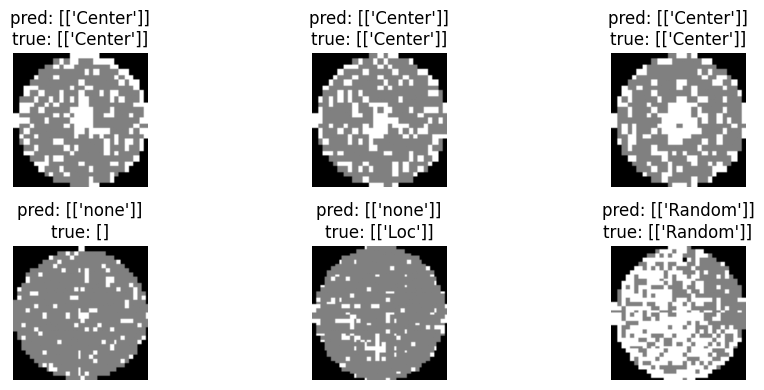

In [ ]:
import matplotlib.pyplot as plt

model.eval()
xb, yb = next(iter(val_loader))
with torch.no_grad():
    logits = model(xb.to(device))
    preds = logits.argmax(1).cpu().numpy()

plt.figure(figsize=(10,4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(xb[i,0].numpy(), cmap="gray")
    plt.title(f"pred: {classes[preds[i]]}\ntrue: {classes[yb[i].item()]}")
    plt.axis("off")
plt.tight_layout(); plt.show()


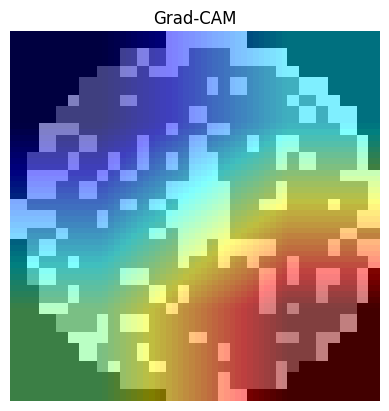

In [ ]:
!pip install -q grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

model.eval()
target_layer = model.layer4[-1]

cam = None
try:
    cam = GradCAM(model=model, target_layers=[target_layer])

    img = xb[0:1].to(device)
    grayscale_cam = cam(input_tensor=img)[0]
    base = xb[0].permute(1,2,0).numpy()
    base = base / (base.max() + 1e-6)
    heat = show_cam_on_image(base, grayscale_cam, use_rgb=True)

    plt.imshow(heat); plt.axis("off"); plt.title("Grad-CAM")
    plt.show()
finally:
    if cam is not None:
        cam.activations_and_grads.release()

In [ ]:
df

NameError: name 'df' is not defined